In [ ]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


# VAH## 파일이 들어있는 폴더 
DATA_DIR = r"D:\eVTOL dataset\ML project" 


# 사용할 파일 목록 20개
vah_list = [
    "VAH01","VAH02","VAH06","VAH07","VAH09","VAH10","VAH11","VAH12","VAH13",
    "VAH15","VAH16","VAH17","VAH20","VAH22","VAH24","VAH25","VAH26","VAH27", "VAH28", "VAH30"
] 


# column 이름
t_col     = "time_s"
v_col     = "Ecell_V"
i_col     = "I_mA"
temp_col  = "Temperature__C"
cycle_col = "new_cycle"
valid_col = "valid_cycle"
rpt_col   = "RPT_cycle"
soc_col   = "SOC_shifted"

#----------------------------------------------------------------
# 1. 전체 파일 읽기
    # 파일을 모두 읽어서 각 row가 어느 파일의 row인지 표시한다.
    # 이후 셀 단위로 train/test set을 구분한다.
     
def load_cells(data_dir, cell_names):
    dfs = []
    for cell in cell_names:
        fp = os.path.join(data_dir, f"{cell}.csv")
        d = pd.read_csv(fp)
        d["cell_id"] = cell
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True)

df = load_cells(DATA_DIR, vah_list)


#---------------------------------------------------------------
# 2. SOC 추정 사이클과 구간 마킹
    # SOC 추정을 할 사이클은 valid 한 사이클 중 RPT 사이클이 아닌 사이클이며, 
    # discharge 구간에서만 SOC를 추정한다.

mask = (
    (df[valid_col] == True) &
    (df[rpt_col] == False) &
    (df[i_col] < 0)
)

use_cols = ["cell_id", cycle_col, t_col, v_col, i_col, temp_col, soc_col]
dfd = df.loc[mask, use_cols].copy()
dfd = dfd.dropna(subset=use_cols)
dfd = dfd.sort_values(["cell_id", cycle_col, t_col])


#-----------------------------------------------------------------
# 3. SOC cliping
    # SOC가 물리적으로 불가능한 값을 가지지 않도록 clip한다. 

dfd[soc_col] = dfd[soc_col].astype(float).clip(0.0, 1.0)


#-----------------------------------------------------------------
# 4. cycle number 재설정
    # valid, non-RPT 사이클만 남기게 되면
    # 사이클 번호에 불연속이 발생한다. 
    # 따라서 추정 사이클이 연속적인 번호를 가질 수 있도록 재설정한다. 
pairs = (
    dfd[["cell_id", cycle_col]]
    .drop_duplicates()
    .sort_values(["cell_id", cycle_col])
)
pairs["cycle_ml"] = pairs.groupby("cell_id").cumcount() + 1

dfd = dfd.merge(pairs, on=["cell_id", cycle_col], how="left")


#---------------------------------------------------------------
# 5. train/test split
    # 전체 20개의 파일 중, 20개를 랜덤하게 골라서 training에 사용한다. 

all_cells = sorted(dfd["cell_id"].unique())
rng = np.random.RandomState(42)

n_test = max(1, int(round(0.2 * len(all_cells))))  # 20개면 보통 4개
test_cells = sorted(rng.choice(all_cells, size=n_test, replace=False))
train_cells = [c for c in all_cells if c not in test_cells]

train_df = dfd.loc[dfd["cell_id"].isin(train_cells)].copy()
test_df  = dfd.loc[dfd["cell_id"].isin(test_cells)].copy()

print("Train cells:", train_cells)
print("Test cells :", test_cells)
print("Train rows :", len(train_df), " Test rows:", len(test_df))


#---------------------------------------------------------------
# 6. 모델 학습
    # 입력 변수로 전압, 전류, 온도를 사용한다. 
X_train = train_df[[v_col, i_col, temp_col]].to_numpy(dtype=float)
y_train = train_df[soc_col].to_numpy(dtype=float)

X_test  = test_df[[v_col, i_col, temp_col]].to_numpy(dtype=float)
y_test  = test_df[soc_col].to_numpy(dtype=float)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=3
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE  = {mae:.5f}")
print(f"Test RMSE = {rmse:.5f}")

#-----------------------------------------------------------------------
# 7. 각 파일 별 MAE 출력
test_df = test_df.copy()
test_df["pred"] = y_pred
cell_mae = (
    test_df.groupby("cell_id")
           .apply(lambda g: mean_absolute_error(g[soc_col].to_numpy(), g["pred"].to_numpy()))
           .sort_values()
)
print("\nMAE by test cell:")
print(cell_mae)


Train cells: ['VAH06', 'VAH07', 'VAH09', 'VAH10', 'VAH11', 'VAH12', 'VAH13', 'VAH15', 'VAH16', 'VAH17', 'VAH20', 'VAH22', 'VAH24', 'VAH26', 'VAH28', 'VAH30']
Test cells : ['VAH01', 'VAH02', 'VAH25', 'VAH27']
Train rows : 1526379  Test rows: 892204
Test MAE  = 0.01614
Test RMSE = 0.03161

MAE by test cell:
cell_id
VAH27    0.012854
VAH02    0.013376
VAH01    0.019073
VAH25    0.019187
dtype: float64


C:\Users\zzxcv\AppData\Local\Temp\ipykernel_3968\1127648715.py:122: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mean_absolute_error(g[soc_col].to_numpy(), g["pred"].to_numpy()))


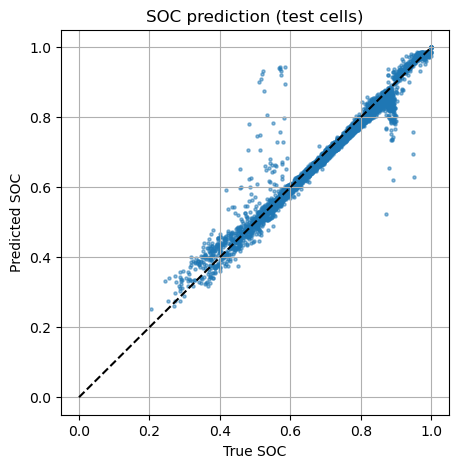

In [ ]:
# 산점도 plot
    # 너무 많으면 점이 뭉개지니까 일부만 샘플링한다. 
n_plot = min(5000, len(test_df))
idx = np.random.RandomState(0).choice(len(test_df), size=n_plot, replace=False)

plt.figure(figsize=(5,5))
plt.scatter(
    test_df[soc_col].iloc[idx],
    test_df["pred"].iloc[idx],
    s=5,
    alpha=0.5
)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("True SOC")
plt.ylabel("Predicted SOC")
plt.title("SOC prediction (test cells)")
plt.grid(True)
plt.show()


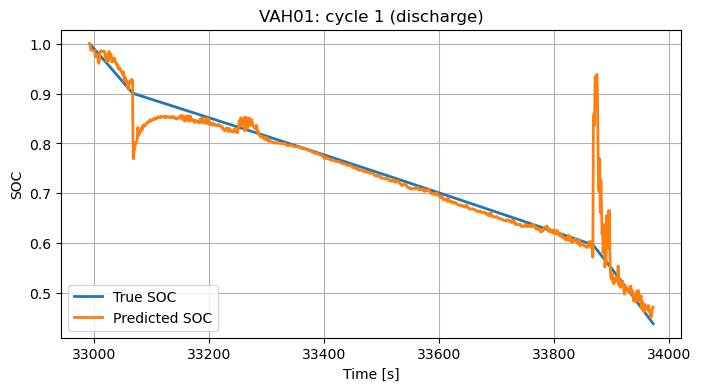

In [ ]:
# Model SOC vs. True SOC plot
    # 임의로 plot할 사이클을 잡고 그래프 그리기
cell = test_df["cell_id"].iloc[450]


cycle = test_df[test_df["cell_id"] == cell]["cycle_ml"].iloc[0]

g = test_df[
    (test_df["cell_id"] == cell) &
    (test_df["cycle_ml"] == cycle)
].sort_values("time_s")

plt.figure(figsize=(8,4))
plt.plot(g["time_s"], g[soc_col], label="True SOC", linewidth=2)
plt.plot(g["time_s"], g["pred"], label="Predicted SOC", linewidth=2)
plt.xlabel("Time [s]")
plt.ylabel("SOC")
plt.title(f"{cell}: cycle {cycle} (discharge)")
plt.legend()
plt.grid(True)
plt.show()
